<class 'pandas.core.frame.DataFrame'>
Index: 496827 entries, 48321 to 929187
Data columns (total 12 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   counter_id                 496827 non-null  category      
 1   counter_name               496827 non-null  category      
 2   site_id                    496827 non-null  int64         
 3   site_name                  496827 non-null  category      
 4   bike_count                 496827 non-null  float64       
 5   date                       496827 non-null  datetime64[us]
 6   counter_installation_date  496827 non-null  datetime64[us]
 7   coordinates                496827 non-null  category      
 8   counter_technical_id       496827 non-null  category      
 9   latitude                   496827 non-null  float64       
 10  longitude                  496827 non-null  float64       
 11  log_bike_count             496827 non-null  float64  

/var/folders/dr/m9v4shms079d9s6z6c8cg57m0000gn/T/ipykernel_73344/1192055722.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby(["site_name", "counter_name"])["bike_count"].sum()


Note: you may need to restart the kernel to use updated packages.


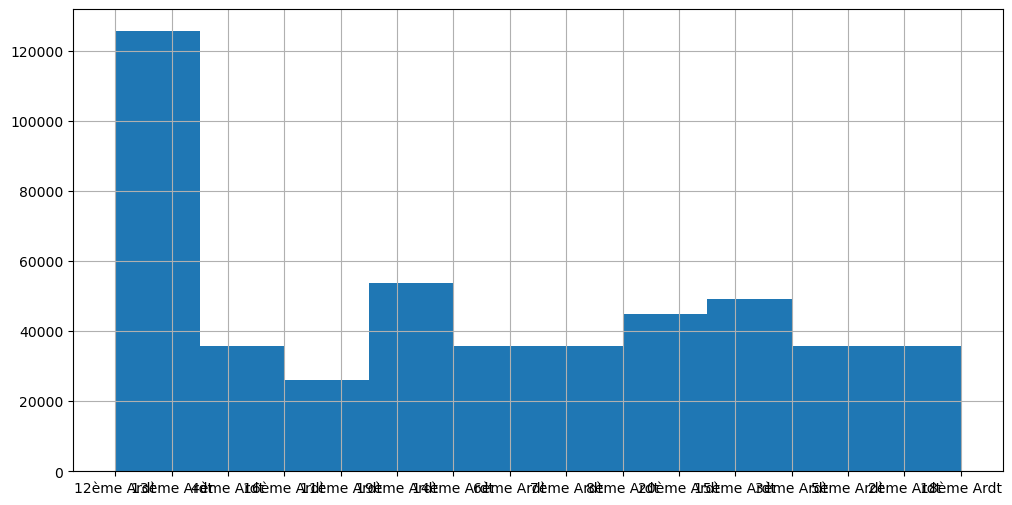

In [1]:
%run "/Users/thom/Desktop/DSB/bike_counters_/feature_engineering.ipynb"

In [ ]:
%run "/Users/valentinhenryleo/Documents/Polytechnique/Python/Python_kaggle/bike_counters_/Feature_engineering/feature_engineering.ipynb"

In [2]:
import holidays
fr_holidays = holidays.France(years=[2020,2021])

def _encode_dates(X):
    X = X.copy()  # modify a copy of X
    # Encode the date information from the Date columns
    X["year"] = X["date"].dt.year
    X["month"] = X["date"].dt.month
    X["day"] = X["date"].dt.day
    X["weekday"] = X["date"].dt.weekday
    X["hour"] = X["date"].dt.hour
    X['bankholidays'] = X['date'].isin(fr_holidays).astype(int)
    X['weekend'] = X['weekday'].isin([6,7]).astype(int)
    X['night'] = X['hour'].isin([20, 21, 22, 23, 24, 1, 2, 3, 4, 5, 6]).astype(int)
    X['morning'] = X['hour'].isin([6, 7, 8, 9, 10, 11, 12]).astype(int)
    X['midday'] = X['hour'].isin([12, 13, 14]).astype(int)
    X['evening'] = X['hour'].isin([14, 15, 16, 17, 18, 19, 20]).astype(int)

    # Finally we can drop the original columns from the dataframe
    return X.drop(columns=["date"])

In [3]:
# Here we cheat a bit and use the function located in utils in order to replace data with the processed data we want from feature_engineering
_target_column_name = "log_bike_count"
def get_train_data(data):
    data = data.sort_values(["date", "counter_name"])
    y_array = data[_target_column_name].values
    X_df = data.drop([_target_column_name, "bike_count"], axis=1)
    return X_df, y_array

In [4]:
X, y = get_train_data(data_bike_arr_rid) # to replace with the processed data from feature_engineering we want to use

In [5]:
def train_test_split_temporal(X, y, delta_threshold="30 days"):

    cutoff_date = X["date"].max() - pd.Timedelta(delta_threshold)
    mask = (X["date"] <= cutoff_date)
    X_train, X_valid = X.loc[mask], X.loc[~mask]
    y_train, y_valid = y[mask], y[~mask]

    return X_train, y_train, X_valid, y_valid

In [6]:
X_train, y_train, X_valid, y_valid = train_test_split_temporal(X,y)

print(
    f'Train: n_samples={X_train.shape[0]},  {X_train["date"].min()} to {X_train["date"].max()}'
)
print(
    f'Valid: n_samples={X_valid.shape[0]},  {X_valid["date"].min()} to {X_valid["date"].max()}'
)

Train: n_samples=456507,  2020-09-01 01:00:00 to 2021-08-10 23:00:00
Valid: n_samples=40320,  2021-08-11 00:00:00 to 2021-09-09 23:00:00


In [7]:
_encode_dates(X_train[["date"]]).columns.tolist()

/var/folders/dr/m9v4shms079d9s6z6c8cg57m0000gn/T/ipykernel_73344/2368337008.py:12: FutureWarning: The behavior of 'isin' with dtype=datetime64[us] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  X['bankholidays'] = X['date'].isin(fr_holidays).astype(int)


['year',
 'month',
 'day',
 'weekday',
 'hour',
 'bankholidays',
 'weekend',
 'night',
 'morning',
 'midday',
 'evening']

## Ridge without StandardScaler

In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline

date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train[["date"]]).columns.tolist()

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols),
    ]
)

regressor = Ridge()

pipe = make_pipeline(date_encoder, preprocessor, regressor)
pipe.fit(X_train, y_train)

/var/folders/dr/m9v4shms079d9s6z6c8cg57m0000gn/T/ipykernel_73344/2368337008.py:12: FutureWarning: The behavior of 'isin' with dtype=datetime64[us] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  X['bankholidays'] = X['date'].isin(fr_holidays).astype(int)
/var/folders/dr/m9v4shms079d9s6z6c8cg57m0000gn/T/ipykernel_73344/2368337008.py:12: FutureWarning: The behavior of 'isin' with dtype=datetime64[us] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  X['bankholidays'] = X['date'].isin(fr_holidays).astype(int)


Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function _encode_dates at 0x13eab6b60>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour',
                                                   'bankholidays', 'weekend',
                                                   'night', 'morning', 'midday',
                                                   'evening']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name', 'site_name',
                                                   'counter_technical_id',
                                                   'arrondissement'])])),
                ('ridge', Ridge())])

We then evaluate this model with the RMSE metric,

In [10]:
from sklearn.metrics import mean_squared_error

print(
    f"Train set, RMSE={mean_squared_error(y_train, pipe.predict(X_train), squared=False):.2f}"
)
print(
    f"Valid set, RMSE={mean_squared_error(y_valid, pipe.predict(X_valid), squared=False):.2f}"
)

/var/folders/dr/m9v4shms079d9s6z6c8cg57m0000gn/T/ipykernel_73344/2368337008.py:12: FutureWarning: The behavior of 'isin' with dtype=datetime64[us] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  X['bankholidays'] = X['date'].isin(fr_holidays).astype(int)


Train set, RMSE=0.80
Valid set, RMSE=0.73


/Applications/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/var/folders/dr/m9v4shms079d9s6z6c8cg57m0000gn/T/ipykernel_73344/2368337008.py:12: FutureWarning: The behavior of 'isin' with dtype=datetime64[us] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  X['bankholidays'] = X['date'].isin(fr_holidays).astype(int)
/Applications/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


The model doesn't have enough capacity to generalize on the train set, since we have lots of data with relatively few parameters. However it happened to work somewhat better on the test set. We can compare these results with the baseline predicting the mean value,

In [11]:
print("Baseline mean prediction.")
print(
    f"Train set, RMSE={mean_squared_error(y_train, np.full(y_train.shape, y_train.mean()), squared=False):.2f}"
)
print(
    f"Test set, RMSE={mean_squared_error(y_valid, np.full(y_valid.shape, y_valid.mean()), squared=False):.2f}"
)

Baseline mean prediction.
Train set, RMSE=1.67
Test set, RMSE=1.44


/Applications/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Applications/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


which illustrates that we are performing better than the baseline.

Let's visualize the predictions for one of the stations (we transform the logarithmic bike counts back to their original unit):

In [12]:
X_valid.head()

,latitude,longitude,counter_name,site_name,counter_technical_id,date,counter_installation_date,arrondissement
408321,48.840801,2.333233,152 boulevard du Montparnasse E-O,152 boulevard du Montparnasse,Y2H19070373,2021-08-11,2018-12-07,6ème Ardt
418197,48.840801,2.333233,152 boulevard du Montparnasse O-E,152 boulevard du Montparnasse,Y2H19070373,2021-08-11,2018-12-07,6ème Ardt
95381,48.853720,2.357020,18 quai de l'Hôtel de Ville NO-SE,18 quai de l'Hôtel de Ville,Y2H19027732,2021-08-11,2017-07-12,4ème Ardt
105609,48.853720,2.357020,18 quai de l'Hôtel de Ville SE-NO,18 quai de l'Hôtel de Ville,Y2H19027732,2021-08-11,2017-07-12,4ème Ardt
883986,48.885290,2.326660,20 Avenue de Clichy NO-SE,20 Avenue de Clichy,Y2H20073268,2021-08-11,2020-07-22,18ème Ardt


In [13]:
mask = (
    (X_valid["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (X_valid["date"] > pd.to_datetime("2021/09/01"))
    & (X_valid["date"] < pd.to_datetime("2021/09/08"))
)

df_viz = X_valid.loc[mask].copy()
df_viz["bike_count"] = np.exp(y_valid[mask.values]) - 1
df_viz["bike_count (predicted)"] = np.exp(pipe.predict(X_valid[mask])) - 1

df_viz

/var/folders/dr/m9v4shms079d9s6z6c8cg57m0000gn/T/ipykernel_73344/2368337008.py:12: FutureWarning: The behavior of 'isin' with dtype=datetime64[us] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  X['bankholidays'] = X['date'].isin(fr_holidays).astype(int)


,latitude,longitude,counter_name,site_name,counter_technical_id,date,counter_installation_date,arrondissement,bike_count,bike_count (predicted)
834456,48.86377,2.35096,Totem 73 boulevard de Sébastopol S-N,Totem 73 boulevard de Sébastopol,YTH19111510,2021-09-01 01:00:00,2020-02-11,2ème Ardt,17.0,19.937799
832154,48.86377,2.35096,Totem 73 boulevard de Sébastopol S-N,Totem 73 boulevard de Sébastopol,YTH19111510,2021-09-01 02:00:00,2020-02-11,2ème Ardt,11.0,18.422030
832157,48.86377,2.35096,Totem 73 boulevard de Sébastopol S-N,Totem 73 boulevard de Sébastopol,YTH19111510,2021-09-01 03:00:00,2020-02-11,2ème Ardt,18.0,25.246507
834459,48.86377,2.35096,Totem 73 boulevard de Sébastopol S-N,Totem 73 boulevard de Sébastopol,YTH19111510,2021-09-01 04:00:00,2020-02-11,2ème Ardt,40.0,51.843543
834919,48.86377,2.35096,Totem 73 boulevard de Sébastopol S-N,Totem 73 boulevard de Sébastopol,YTH19111510,2021-09-01 05:00:00,2020-02-11,2ème Ardt,132.0,131.621598
...,...,...,...,...,...,...,...,...,...,...
834633,48.86377,2.35096,Totem 73 boulevard de Sébastopol S-N,Totem 73 boulevard de Sébastopol,YTH19111510,2021-09-07 19:00:00,2020-02-11,2ème Ardt,417.0,270.814364
834636,48.86377,2.35096,Totem 73 boulevard de Sébastopol S-N,Totem 73 boulevard de Sébastopol,YTH19111510,2021-09-07 20:00:00,2020-02-11,2ème Ardt,446.0,156.774415
835051,48.86377,2.35096,Totem 73 boulevard de Sébastopol S-N,Totem 73 boulevard de Sébastopol,YTH19111510,2021-09-07 21:00:00,2020-02-11,2ème Ardt,466.0,95.870186
834639,48.86377,2.35096,Totem 73 boulevard de Sébastopol S-N,Totem 73 boulevard de Sébastopol,YTH19111510,2021-09-07 22:00:00,2020-02-11,2ème Ardt,195.0,58.115824


Text(0, 0.5, 'bike_count')

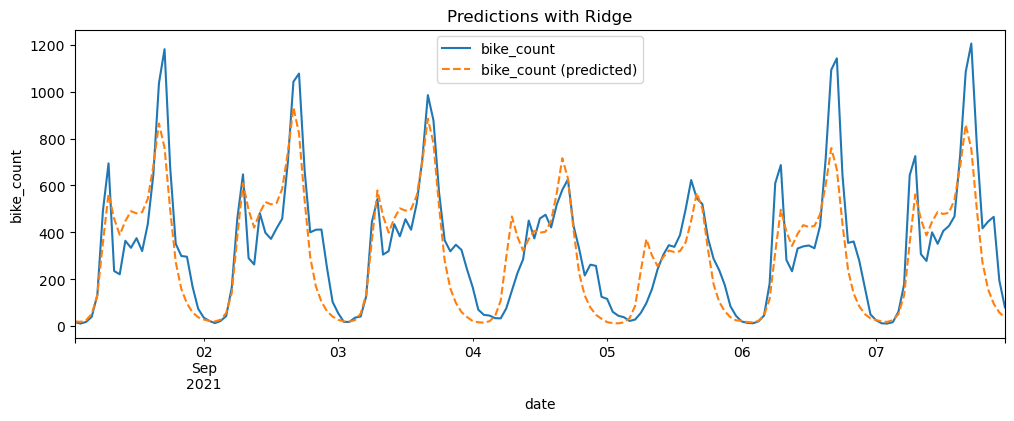

In [14]:
fig, ax = plt.subplots(figsize=(12, 4))

df_viz.plot(x="date", y="bike_count", ax=ax)
df_viz.plot(x="date", y="bike_count (predicted)", ax=ax, ls="--")
ax.set_title("Predictions with Ridge")
ax.set_ylabel("bike_count")

So we start to see the daily trend, and some of the week day differences are accounted for, however we still miss the details and the spikes in the evening are under-estimated.

A useful way to visualize the error is to plot `y_pred` as a function of `y_true`,

/var/folders/dr/m9v4shms079d9s6z6c8cg57m0000gn/T/ipykernel_73344/2368337008.py:12: FutureWarning: The behavior of 'isin' with dtype=datetime64[us] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  X['bankholidays'] = X['date'].isin(fr_holidays).astype(int)


<Axes: xlabel='y_true', ylabel='y_pred'>

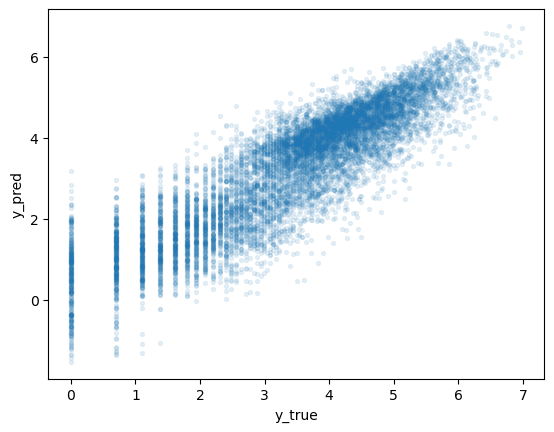

In [15]:
fig, ax = plt.subplots()

df_viz = pd.DataFrame({"y_true": y_valid, "y_pred": pipe.predict(X_valid)}).sample(
    10000, random_state=0
)

df_viz.plot.scatter(x="y_true", y="y_pred", s=8, alpha=0.1, ax=ax)

It is recommended to use cross-validation for hyper-parameter tuning with [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) or more reliable model evaluation with [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score). In this case, because we want the test data to always be in the future as compared to the train data, we can use [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html):

<img src="https://i.stack.imgur.com/Q37Bn.png" />

The disadvantage, is that we can either have the training set size be different for each fold which is not ideal for hyper-parameter tuning (current figure), or have constant sized small training set which is also not ideal given the data periodicity. This explains that generally we will have worse cross-validation scores than test scores:

In [16]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

cv = TimeSeriesSplit(n_splits=6)

# When using a scorer in scikit-learn it always needs to be better when smaller, hence the minus sign.
scores = cross_val_score(
    pipe, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error"
)
print("RMSE: ", scores)
print(f"RMSE (all folds): {-scores.mean():.3} ± {(-scores).std():.3}")

/var/folders/dr/m9v4shms079d9s6z6c8cg57m0000gn/T/ipykernel_73344/2368337008.py:12: FutureWarning: The behavior of 'isin' with dtype=datetime64[us] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  X['bankholidays'] = X['date'].isin(fr_holidays).astype(int)
/var/folders/dr/m9v4shms079d9s6z6c8cg57m0000gn/T/ipykernel_73344/2368337008.py:12: FutureWarning: The behavior of 'isin' with dtype=datetime64[us] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  X['bankholidays'] = X['date'].isin(fr_holidays).astype(int)
/var/folders/dr/m9v4shms079d9s6z6c8cg57m0000gn/T/ipykernel_73344/2368337008.py:12: FutureWarning: The behavior of 'isin' with dtype=datetime64[us] and castable values (e.g. strings) is deprecated. In a futu

RMSE:  [-0.96367278 -0.87151092 -0.8510738  -0.87391172 -1.0638926  -0.96787927]
RMSE (all folds): 0.932 ± 0.0745


/var/folders/dr/m9v4shms079d9s6z6c8cg57m0000gn/T/ipykernel_73344/2368337008.py:12: FutureWarning: The behavior of 'isin' with dtype=datetime64[us] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  X['bankholidays'] = X['date'].isin(fr_holidays).astype(int)


In [ ]:
X_valid = pd.read_parquet(Path("data") / "final_test.parquet")
data.head()

In [ ]:
y_pred = pipe.predict(X_valid)

results = pd.DataFrame(
    dict(
        Id=np.arange(y_pred.shape[0]),
        log_bike_count=y_pred,
    )
)
results.to_csv("submission.csv", index=False)


## Ridge with StandardScaler

In [17]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train[["date"]]).columns.tolist()

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

numerical_encoder = StandardScaler()
numerical_columns = X_train.select_dtypes(include=['number']).columns.tolist()


preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols),
        ("num", numerical_encoder, numerical_columns),
    ]
)

regressor = Ridge()

pipe = make_pipeline(date_encoder, preprocessor, regressor)
pipe.fit(X_train, y_train)

/var/folders/dr/m9v4shms079d9s6z6c8cg57m0000gn/T/ipykernel_73344/2368337008.py:12: FutureWarning: The behavior of 'isin' with dtype=datetime64[us] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  X['bankholidays'] = X['date'].isin(fr_holidays).astype(int)
/var/folders/dr/m9v4shms079d9s6z6c8cg57m0000gn/T/ipykernel_73344/2368337008.py:12: FutureWarning: The behavior of 'isin' with dtype=datetime64[us] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  X['bankholidays'] = X['date'].isin(fr_holidays).astype(int)


Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function _encode_dates at 0x13eab6b60>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour',
                                                   'bankholidays', 'weekend',
                                                   'night', 'morning', 'midday',
                                                   'evening']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name', 'site_name',
                                                   'counter_technical_id',
                                                   'arrondissement']),
                                                 ('num', StandardScaler(),
                                                  ['latitude', 'longitude'])])),
                ('ridge', Ridge())])

We then evaluate this model with the RMSE metric,

In [18]:
from sklearn.metrics import mean_squared_error

print(
    f"Train set, RMSE={mean_squared_error(y_train, pipe.predict(X_train), squared=False):.2f}"
)
print(
    f"Valid set, RMSE={mean_squared_error(y_valid, pipe.predict(X_valid), squared=False):.2f}"
)

/var/folders/dr/m9v4shms079d9s6z6c8cg57m0000gn/T/ipykernel_73344/2368337008.py:12: FutureWarning: The behavior of 'isin' with dtype=datetime64[us] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  X['bankholidays'] = X['date'].isin(fr_holidays).astype(int)


Train set, RMSE=0.80
Valid set, RMSE=0.73


/Applications/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/var/folders/dr/m9v4shms079d9s6z6c8cg57m0000gn/T/ipykernel_73344/2368337008.py:12: FutureWarning: The behavior of 'isin' with dtype=datetime64[us] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  X['bankholidays'] = X['date'].isin(fr_holidays).astype(int)
/Applications/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


The model doesn't have enough capacity to generalize on the train set, since we have lots of data with relatively few parameters. However it happened to work somewhat better on the test set. We can compare these results with the baseline predicting the mean value,

In [19]:
print("Baseline mean prediction.")
print(
    f"Train set, RMSE={mean_squared_error(y_train, np.full(y_train.shape, y_train.mean()), squared=False):.2f}"
)
print(
    f"Test set, RMSE={mean_squared_error(y_valid, np.full(y_valid.shape, y_valid.mean()), squared=False):.2f}"
)

Baseline mean prediction.
Train set, RMSE=1.67
Test set, RMSE=1.44


/Applications/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Applications/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


which illustrates that we are performing better than the baseline.

Let's visualize the predictions for one of the stations (we transform the logarithmic bike counts back to their original unit):

In [20]:
X_valid.head()

,latitude,longitude,counter_name,site_name,counter_technical_id,date,counter_installation_date,arrondissement
408321,48.840801,2.333233,152 boulevard du Montparnasse E-O,152 boulevard du Montparnasse,Y2H19070373,2021-08-11,2018-12-07,6ème Ardt
418197,48.840801,2.333233,152 boulevard du Montparnasse O-E,152 boulevard du Montparnasse,Y2H19070373,2021-08-11,2018-12-07,6ème Ardt
95381,48.853720,2.357020,18 quai de l'Hôtel de Ville NO-SE,18 quai de l'Hôtel de Ville,Y2H19027732,2021-08-11,2017-07-12,4ème Ardt
105609,48.853720,2.357020,18 quai de l'Hôtel de Ville SE-NO,18 quai de l'Hôtel de Ville,Y2H19027732,2021-08-11,2017-07-12,4ème Ardt
883986,48.885290,2.326660,20 Avenue de Clichy NO-SE,20 Avenue de Clichy,Y2H20073268,2021-08-11,2020-07-22,18ème Ardt


In [21]:
mask = (
    (X_valid["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (X_valid["date"] > pd.to_datetime("2021/09/01"))
    & (X_valid["date"] < pd.to_datetime("2021/09/08"))
)

df_viz = X_valid.loc[mask].copy()
df_viz["bike_count"] = np.exp(y_valid[mask.values]) - 1
df_viz["bike_count (predicted)"] = np.exp(pipe.predict(X_valid[mask])) - 1

/var/folders/dr/m9v4shms079d9s6z6c8cg57m0000gn/T/ipykernel_73344/2368337008.py:12: FutureWarning: The behavior of 'isin' with dtype=datetime64[us] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  X['bankholidays'] = X['date'].isin(fr_holidays).astype(int)


,latitude,longitude,counter_name,site_name,counter_technical_id,date,counter_installation_date,arrondissement,bike_count,bike_count (predicted)
834456,48.86377,2.35096,Totem 73 boulevard de Sébastopol S-N,Totem 73 boulevard de Sébastopol,YTH19111510,2021-09-01 01:00:00,2020-02-11,2ème Ardt,17.0,19.936932
832154,48.86377,2.35096,Totem 73 boulevard de Sébastopol S-N,Totem 73 boulevard de Sébastopol,YTH19111510,2021-09-01 02:00:00,2020-02-11,2ème Ardt,11.0,18.421226
832157,48.86377,2.35096,Totem 73 boulevard de Sébastopol S-N,Totem 73 boulevard de Sébastopol,YTH19111510,2021-09-01 03:00:00,2020-02-11,2ème Ardt,18.0,25.245419
834459,48.86377,2.35096,Totem 73 boulevard de Sébastopol S-N,Totem 73 boulevard de Sébastopol,YTH19111510,2021-09-01 04:00:00,2020-02-11,2ème Ardt,40.0,51.841351
834919,48.86377,2.35096,Totem 73 boulevard de Sébastopol S-N,Totem 73 boulevard de Sébastopol,YTH19111510,2021-09-01 05:00:00,2020-02-11,2ème Ardt,132.0,131.616090
...,...,...,...,...,...,...,...,...,...,...
834633,48.86377,2.35096,Totem 73 boulevard de Sébastopol S-N,Totem 73 boulevard de Sébastopol,YTH19111510,2021-09-07 19:00:00,2020-02-11,2ème Ardt,417.0,270.822181
834636,48.86377,2.35096,Totem 73 boulevard de Sébastopol S-N,Totem 73 boulevard de Sébastopol,YTH19111510,2021-09-07 20:00:00,2020-02-11,2ème Ardt,446.0,156.781109
835051,48.86377,2.35096,Totem 73 boulevard de Sébastopol S-N,Totem 73 boulevard de Sébastopol,YTH19111510,2021-09-07 21:00:00,2020-02-11,2ème Ardt,466.0,95.868126
834639,48.86377,2.35096,Totem 73 boulevard de Sébastopol S-N,Totem 73 boulevard de Sébastopol,YTH19111510,2021-09-07 22:00:00,2020-02-11,2ème Ardt,195.0,58.114569


Text(0, 0.5, 'bike_count')

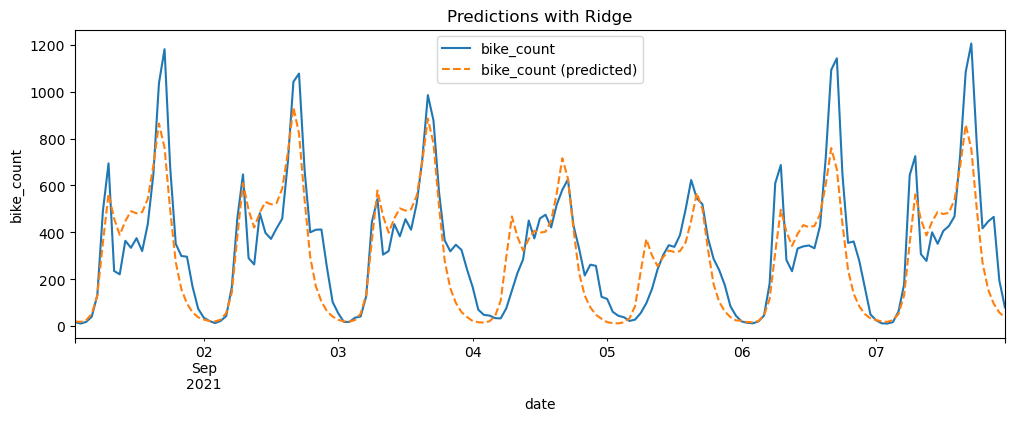

In [22]:
fig, ax = plt.subplots(figsize=(12, 4))

df_viz.plot(x="date", y="bike_count", ax=ax)
df_viz.plot(x="date", y="bike_count (predicted)", ax=ax, ls="--")
ax.set_title("Predictions with Ridge")
ax.set_ylabel("bike_count")

So we start to see the daily trend, and some of the week day differences are accounted for, however we still miss the details and the spikes in the evening are under-estimated.

A useful way to visualize the error is to plot `y_pred` as a function of `y_true`,

In [ ]:
fig, ax = plt.subplots()

df_viz = pd.DataFrame({"y_true": y_valid, "y_pred": pipe.predict(X_valid)}).sample(
    10000, random_state=0
)

df_viz.plot.scatter(x="y_true", y="y_pred", s=8, alpha=0.1, ax=ax)

It is recommended to use cross-validation for hyper-parameter tuning with [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) or more reliable model evaluation with [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score). In this case, because we want the test data to always be in the future as compared to the train data, we can use [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html):

<img src="https://i.stack.imgur.com/Q37Bn.png" />

The disadvantage, is that we can either have the training set size be different for each fold which is not ideal for hyper-parameter tuning (current figure), or have constant sized small training set which is also not ideal given the data periodicity. This explains that generally we will have worse cross-validation scores than test scores:

In [ ]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

cv = TimeSeriesSplit(n_splits=6)

# When using a scorer in scikit-learn it always needs to be better when smaller, hence the minus sign.
scores = cross_val_score(
    pipe, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error"
)
print("RMSE: ", scores)
print(f"RMSE (all folds): {-scores.mean():.3} ± {(-scores).std():.3}")

In [ ]:
X_valid = pd.read_parquet(Path("data") / "final_test.parquet")
data.head()

In [ ]:
y_pred = pipe.predict(X_valid)

results = pd.DataFrame(
    dict(
        Id=np.arange(y_pred.shape[0]),
        log_bike_count=y_pred,
    )
)
results.to_csv("submission.csv", index=False)
